----- Training Single‐Gaussian Network -----
[Gaussian] Epoch 1/80, Loss = -0.9234
[Gaussian] Epoch 2/80, Loss = -1.6847
[Gaussian] Epoch 3/80, Loss = -1.7022
[Gaussian] Epoch 4/80, Loss = -1.7222
[Gaussian] Epoch 5/80, Loss = -1.7474
[Gaussian] Epoch 6/80, Loss = -1.7207
[Gaussian] Epoch 7/80, Loss = -1.7559
[Gaussian] Epoch 8/80, Loss = -1.7489
[Gaussian] Epoch 9/80, Loss = -1.7591
[Gaussian] Epoch 10/80, Loss = -1.7545
[Gaussian] Epoch 11/80, Loss = -1.7545
[Gaussian] Epoch 12/80, Loss = -1.7885
[Gaussian] Epoch 13/80, Loss = -1.7758
[Gaussian] Epoch 14/80, Loss = -1.7770
[Gaussian] Epoch 15/80, Loss = -1.7732
[Gaussian] Epoch 16/80, Loss = -1.7649
[Gaussian] Epoch 17/80, Loss = -1.7783
[Gaussian] Epoch 18/80, Loss = -1.7863
[Gaussian] Epoch 19/80, Loss = -1.7752
[Gaussian] Epoch 20/80, Loss = -1.7910
[Gaussian] Epoch 21/80, Loss = -1.7774
[Gaussian] Epoch 22/80, Loss = -1.7906
[Gaussian] Epoch 23/80, Loss = -1.7788
[Gaussian] Epoch 24/80, Loss = -1.7811
[Gaussian] Epoch 25/80, Loss

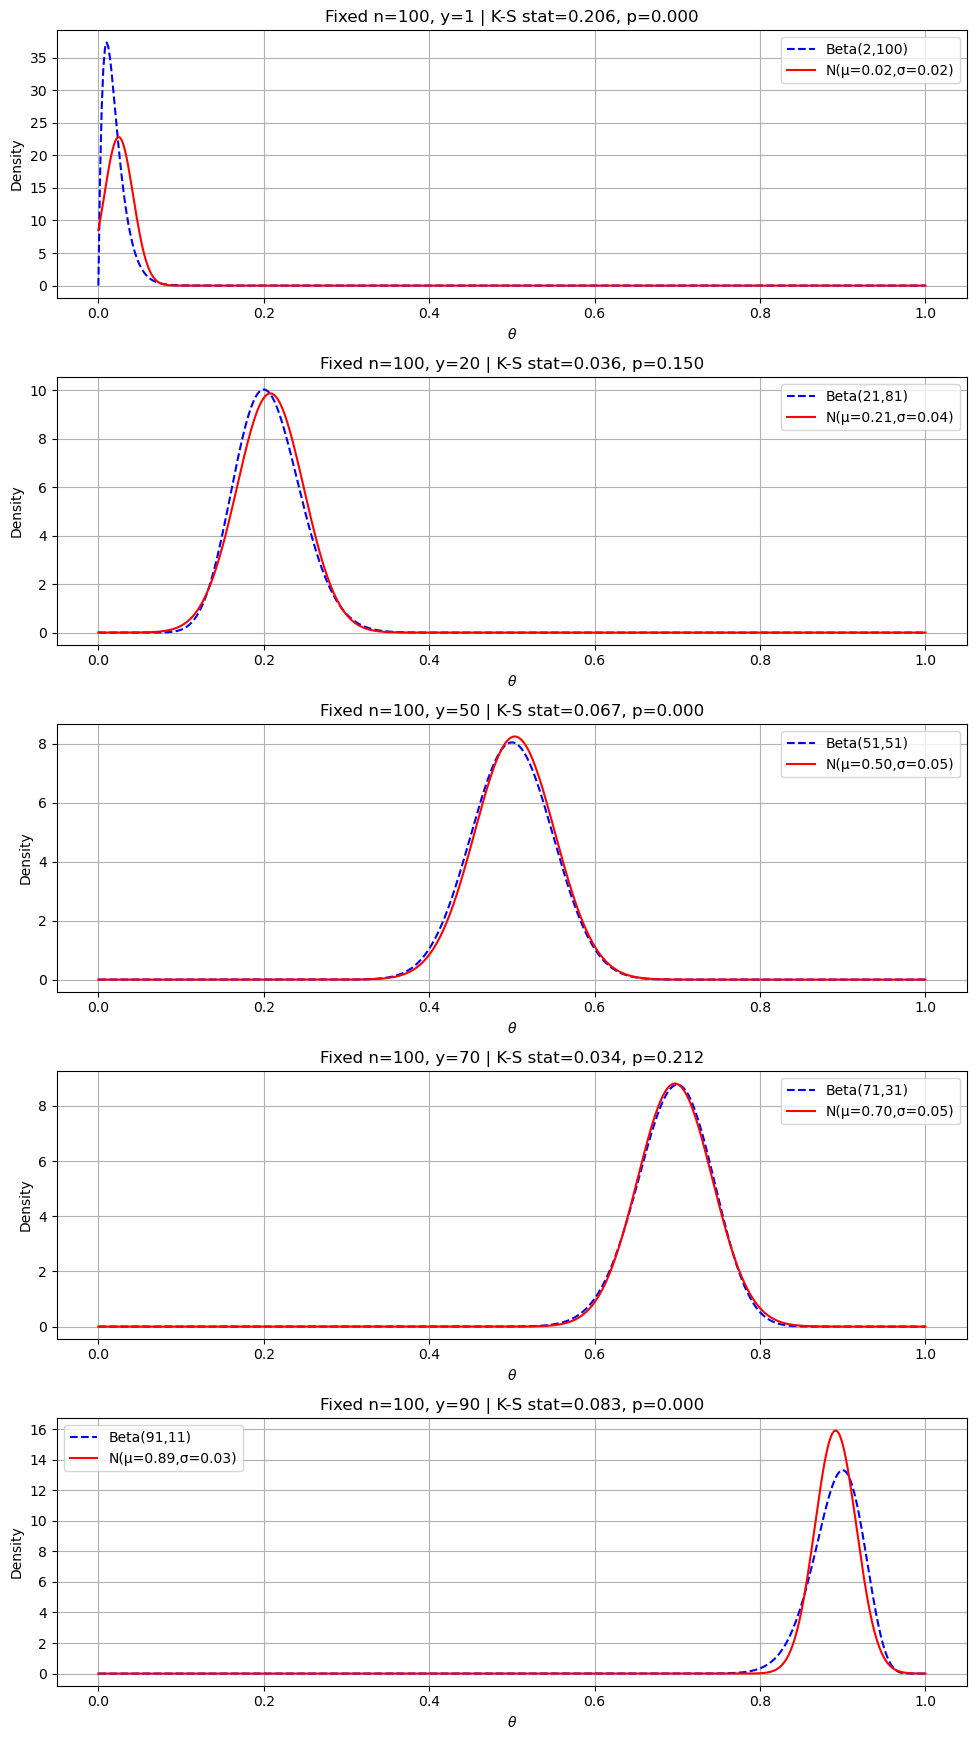


----- Evaluating Single‐Gaussian on Unseen n -----


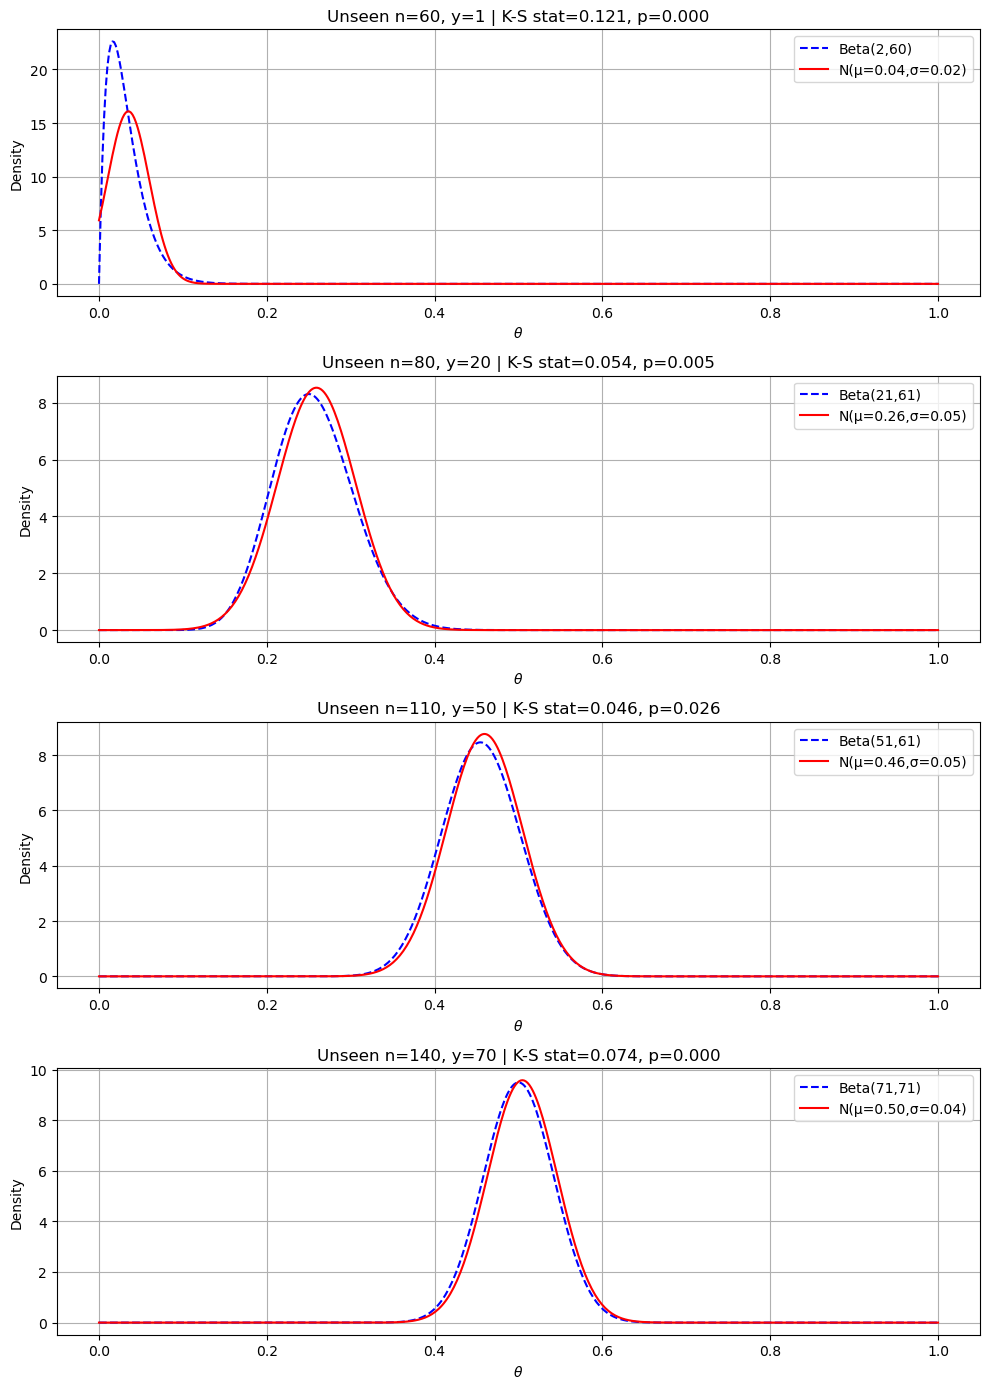


----- Training GMM Network -----
[GMM] Epoch 1/80, Loss = -1.2493
[GMM] Epoch 2/80, Loss = -1.7079
[GMM] Epoch 3/80, Loss = -1.7228
[GMM] Epoch 4/80, Loss = -1.7383
[GMM] Epoch 5/80, Loss = -1.7597
[GMM] Epoch 6/80, Loss = -1.7714
[GMM] Epoch 7/80, Loss = -1.7673
[GMM] Epoch 8/80, Loss = -1.7987
[GMM] Epoch 9/80, Loss = -1.7781
[GMM] Epoch 10/80, Loss = -1.7933
[GMM] Epoch 11/80, Loss = -1.7920
[GMM] Epoch 12/80, Loss = -1.7814
[GMM] Epoch 13/80, Loss = -1.8074
[GMM] Epoch 14/80, Loss = -1.7949
[GMM] Epoch 15/80, Loss = -1.8022
[GMM] Epoch 16/80, Loss = -1.8029
[GMM] Epoch 17/80, Loss = -1.8018
[GMM] Epoch 18/80, Loss = -1.8115
[GMM] Epoch 19/80, Loss = -1.7931
[GMM] Epoch 20/80, Loss = -1.8099
[GMM] Epoch 21/80, Loss = -1.8010
[GMM] Epoch 22/80, Loss = -1.8022
[GMM] Epoch 23/80, Loss = -1.8232
[GMM] Epoch 24/80, Loss = -1.8157
[GMM] Epoch 25/80, Loss = -1.8108
[GMM] Epoch 26/80, Loss = -1.8020
[GMM] Epoch 27/80, Loss = -1.8237
[GMM] Epoch 28/80, Loss = -1.8084
[GMM] Epoch 29/80, Loss

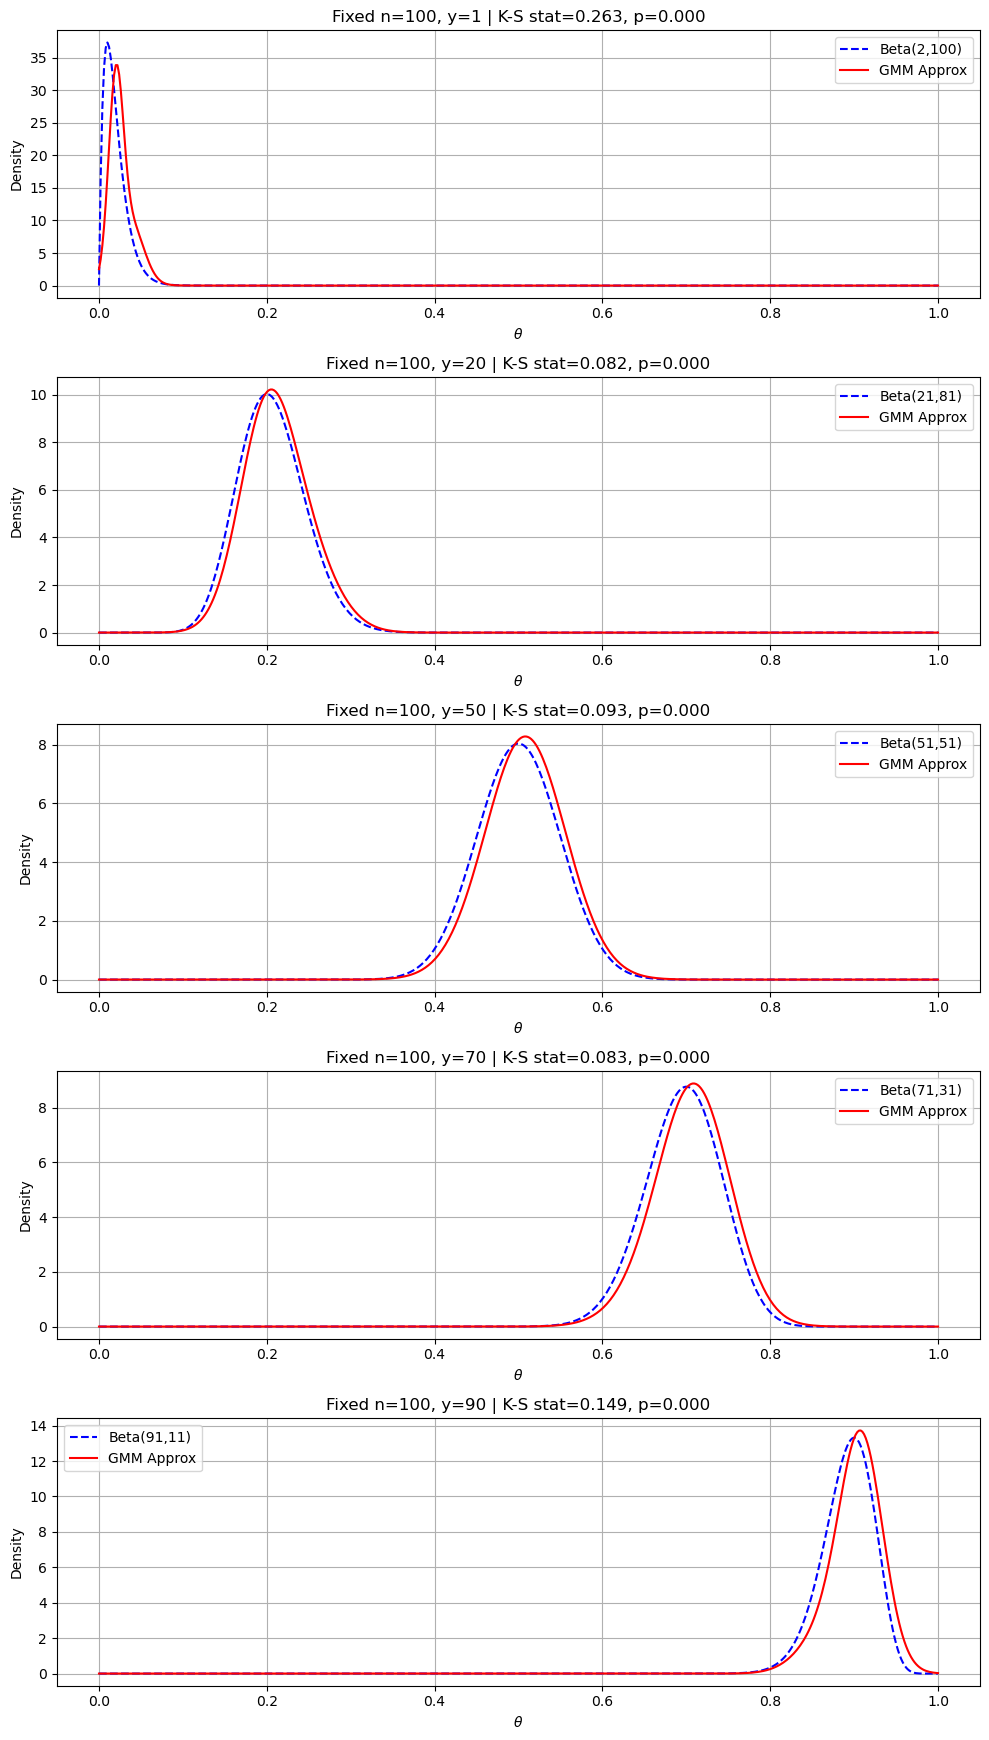


----- Evaluating GMM on Unseen n -----


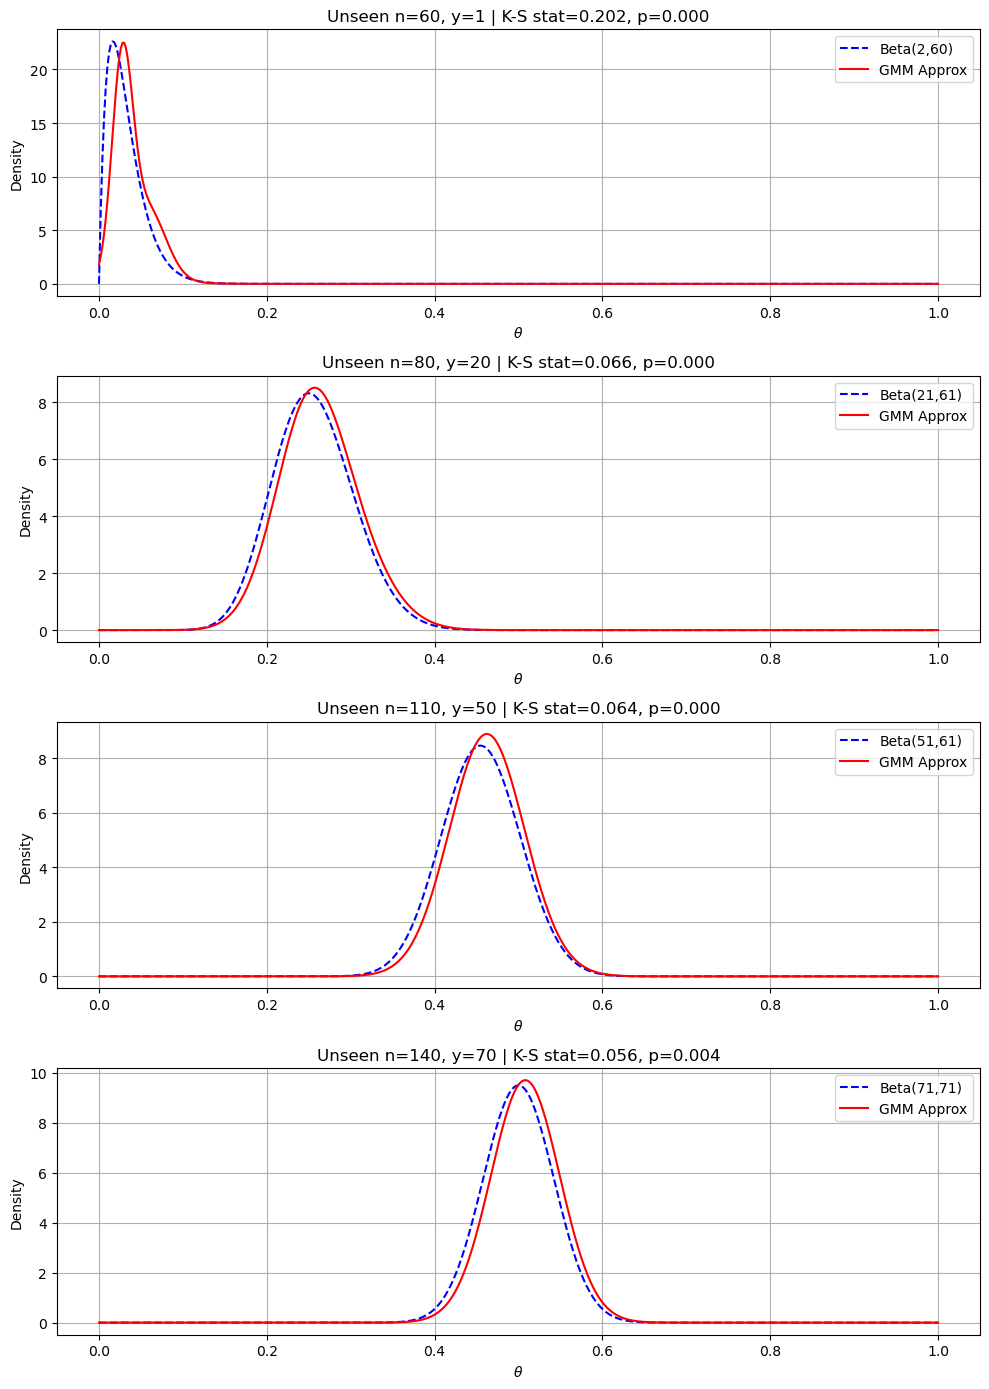

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import beta, norm, ks_2samp
import matplotlib.pyplot as plt

# 1. Generate (theta, y, n) triplets
def generate_theta_y_n(batch_size=256, n_values=[50, 75, 100, 125, 150]):
    """
    For each i in the mini-batch, draw:
      n_i ~ UniformChoice(n_values),
      theta_i ~ Uniform(0,1),
      y_i ~ Binomial(n_i, theta_i).
    Returns numpy arrays y, n, theta of shape (batch_size, 1).
    """
    n     = np.random.choice(n_values, size=(batch_size, 1)).astype(np.float32)
    theta = np.random.uniform(0, 1, size=(batch_size, 1)).astype(np.float32)
    y     = np.random.binomial(n=n.astype(int), p=theta).astype(np.float32)
    return y, n, theta

# 2. Single‐Gaussian Inference Network
class GaussianInferenceNet(nn.Module):
    """
    Input: x_i = [y_i/n_i, log(n_i)] ∈ R^2
    Output: kappa_i = [mu_i, log_sigma_i] ∈ R^2,
    so that posterior ≈ Normal(mu_i, sigma_i^2).
    """
    def __init__(self, hidden_dims=(256, 256, 128)):
        super().__init__()
        layers = []
        in_dim = 2
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, 2))  # outputs [mu, log_sigma]
        self.net = nn.Sequential(*layers)

    def forward(self, y_norm, log_n):
        # y_norm, log_n: each of shape (B,1)
        x = torch.cat([y_norm, log_n], dim=1)  # shape: (B,2)
        return self.net(x)                     # shape: (B,2)

def gaussian_log_likelihood(theta, kappa):
    """
    Compute log p(theta_i | mu_i, sigma_i) = log N(theta_i ; mu_i, sigma_i^2)
    where kappa = [mu, log_sigma].
    theta: (B,) tensor; kappa: (B,2).
    Returns tensor of shape (B,) containing each log-likelihood.
    """
    mu        = kappa[:, 0]            # (B,)
    log_sigma = kappa[:, 1]            # (B,)
    sigma     = torch.exp(log_sigma)   # (B,)
    return -0.5 * ((theta - mu) / sigma) ** 2 \
           - log_sigma         \
           - 0.5 * np.log(2 * np.pi)

def train_gaussian_network(model, optimizer, num_epochs=80, batch_size=256, n_values=None):
    """
    Train single‐Gaussian posterior network by maximizing log-likelihood:
      For each mini-batch:
        1) simulate (y, n, theta)
        2) compute y_norm = y/n, log_n = log(n)
        3) forward -> kappa = [mu, log_sigma]
        4) compute loss = -mean(log N(theta | mu, sigma^2))
        5) backward & optimizer.step()
    """
    for epoch in range(num_epochs):
        total_loss = 0.0
        for _ in range(300):
            # (1) Simulate batch
            y_np, n_np, theta_np = generate_theta_y_n(batch_size=batch_size, n_values=n_values)
            y_norm = torch.from_numpy(y_np / n_np).float()     # (B,1)
            log_n = torch.from_numpy(np.log(n_np)).float()     # (B,1)
            theta = torch.from_numpy(theta_np).squeeze(1).float()  # (B,)

            # (2) Forward + loss
            kappa = model(y_norm, log_n)                       # (B,2)
            log_ll = gaussian_log_likelihood(theta, kappa)     # (B,)
            loss = -log_ll.mean()                              # scalar

            # (3) Backprop + step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / 300
        print(f"[Gaussian] Epoch {epoch+1}/{num_epochs}, Loss = {avg_loss:.4f}")

def evaluate_gaussian_fixed_n(model, fixed_n, y_values, theta_grid):
    """
    For a fixed n (which was in the training set), compare:
      True posterior: Beta(y+1, n-y+1)
      Approximated posterior: N(mu, sigma^2), where [mu, log_sigma] = model([y/n, log n])
    and compute a K-S test on samples.
    """
    K = len(y_values)
    plt.figure(figsize=(10, 3.5 * K))
    for i, y in enumerate(y_values):
        # (A) True Beta posterior
        alpha = y + 1
        beta_param = fixed_n - y + 1
        true_pdf = beta.pdf(theta_grid, alpha, beta_param)

        # (B) Network prediction
        y_norm_tensor = torch.tensor([[y / fixed_n]], dtype=torch.float32)  # (1,1)
        log_n_tensor  = torch.tensor([[np.log(fixed_n)]], dtype=torch.float32)
        with torch.no_grad():
            kappa = model(y_norm_tensor, log_n_tensor)  # (1,2)
        mu    = kappa[0, 0].item()                     # scalar
        sigma = torch.exp(kappa[0, 1]).item()          # scalar
        approx_pdf = norm.pdf(theta_grid, loc=mu, scale=sigma)

        # (C) K-S test
        true_samples   = beta.rvs(alpha, beta_param, size=2000)
        approx_samples = np.random.normal(loc=mu, scale=sigma, size=2000)
        approx_samples = np.clip(approx_samples, 0, 1)
        ks_stat, p_value = ks_2samp(true_samples, approx_samples)

        # (D) Plot
        ax = plt.subplot(K, 1, i + 1)
        ax.plot(theta_grid, true_pdf, 'b--', label=f'Beta({alpha},{beta_param})')
        ax.plot(theta_grid, approx_pdf, 'r-', label=f'N(μ={mu:.2f},σ={sigma:.2f})')
        ax.set_title(f"Fixed n={fixed_n}, y={y} | K-S stat={ks_stat:.3f}, p={p_value:.3f}")
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(f"gaussian_fixedN_{fixed_n}.png", dpi=300)
    plt.show()


def evaluate_gaussian_unseen_n(model, test_cases, theta_grid):
    """
    For each (n,y) in test_cases (where n was NOT in training),
    compare the true Beta posterior vs. the network's predicted Normal,
    and run a K-S test between samples.
    """
    K = len(test_cases)
    plt.figure(figsize=(10, 3.5 * K))
    for i, (n, y) in enumerate(test_cases):
        alpha      = y + 1
        beta_param = n - y + 1
        true_pdf   = beta.pdf(theta_grid, alpha, beta_param)

        y_norm_tensor = torch.tensor([[y / n]], dtype=torch.float32)  # (1,1)
        log_n_tensor  = torch.tensor([[np.log(n)]], dtype=torch.float32)
        with torch.no_grad():
            kappa = model(y_norm_tensor, log_n_tensor)  # (1,2)
        mu    = kappa[0, 0].item()
        sigma = torch.exp(kappa[0, 1]).item()
        approx_pdf = norm.pdf(theta_grid, loc=mu, scale=sigma)

        true_samples   = beta.rvs(alpha, beta_param, size=2000)
        approx_samples = np.random.normal(loc=mu, scale=sigma, size=2000)
        approx_samples = np.clip(approx_samples, 0, 1)
        ks_stat, p_value = ks_2samp(true_samples, approx_samples)

        ax = plt.subplot(K, 1, i + 1)
        ax.plot(theta_grid, true_pdf, 'b--', label=f'Beta({alpha},{beta_param})')
        ax.plot(theta_grid, approx_pdf, 'r-', label=f'N(μ={mu:.2f},σ={sigma:.2f})')
        ax.set_title(f"Unseen n={n}, y={y} | K-S stat={ks_stat:.3f}, p={p_value:.3f}")
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig("gaussian_unseenN.png", dpi=300)
    plt.show()

# 4. GMM Inference Network (Mixture Density Network)
class GMMInferenceNet(nn.Module):
    """
    Input: x_i = [y_i/n_i, log(n_i)] ∈ R^2
    Output: for k=1..K: [logit(pi_k), mu_k, log_sigma_k]
    which defines a K‐component Gaussian mixture:
      p(theta|y,n) ≈ sum_{k=1}^K pi_k N(theta; mu_k, sigma_k^2).
    """
    def __init__(self, num_components=3, hidden_dims=(256, 256, 128)):
        super().__init__()
        self.K = num_components
        layers = []
        in_dim = 2
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, 3 * num_components))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: shape (B,2) = [y/n, log n]
        Returns:
          logits:      (B, K)
          mus:         (B, K)
          log_sigmas:  (B, K)
        """
        out = self.net(x)              # (B, 3K)
        logits     = out[:, :self.K]                 # (B, K)
        mus        = out[:, self.K:2*self.K]         # (B, K)
        log_sigmas = out[:, 2*self.K:]               # (B, K)
        return logits, mus, log_sigmas

def gmm_log_likelihood(theta, logits, mus, log_sigmas):
    """
    Compute negative average log-likelihood of theta under the predicted
    K-component Gaussian mixture.
    p(theta_i) = sum_{k=1}^K pi_{i,k} * N(theta_i; mu_{i,k}, sigma_{i,k}^2),
    where pi_{i,k} = softmax(logits_i)_k, sigma_{i,k} = exp(log_sigmas_{i,k}).
    Returns a scalar tensor (negative average log-likelihood).
    """
    sigmas = torch.exp(log_sigmas)            # (B, K)
    pi     = torch.softmax(logits, dim=1)     # (B, K)
    theta_expanded = theta.unsqueeze(1).expand(-1, mus.size(1))  # (B, K)

    # Component-wise log-density:
    log_probs = -0.5 * ((theta_expanded - mus) / sigmas) ** 2 \
                - log_sigmas \
                - 0.5 * np.log(2 * np.pi)   # (B, K)

    weighted = log_probs + torch.log(pi + 1e-10)    # (B, K)
    log_p_theta = torch.logsumexp(weighted, dim=1) # (B,)
    return -torch.mean(log_p_theta)                 # scalar

def train_gmm_network(model, optimizer, num_epochs=80, batch_size=256, n_values=None):
    """
    Train GMM (Mixture) network:
      1) Sample (y, n, theta)
      2) Compute y_norm = y/n, log_n = log(n), pack into x = (B,2)
      3) Forward: (logits, mus, log_sigmas)
      4) Loss = -mean(log p_GMM(theta)), where p_GMM = sum pi_k N(theta|mu_k,sigma_k^2)
      5) Backward & optimizer.step()
    """
    for epoch in range(num_epochs):
        total_loss = 0.0
        for _ in range(300):
            y_np, n_np, theta_np = generate_theta_y_n(batch_size=batch_size, n_values=n_values)
            y_norm   = torch.from_numpy(y_np / n_np).float()      # (B,1)
            log_n    = torch.from_numpy(np.log(n_np)).float()      # (B,1)
            inputs   = torch.cat([y_norm, log_n], dim=1)          # (B,2)
            theta    = torch.from_numpy(theta_np).squeeze(1).float()  # (B,)

            logits, mus, log_sigmas = model(inputs)  # (B,K)
            loss = gmm_log_likelihood(theta, logits, mus, log_sigmas)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / 300
        print(f"[GMM] Epoch {epoch+1}/{num_epochs}, Loss = {avg_loss:.4f}")

def evaluate_gmm_fixed_n(model, fixed_n, y_values, theta_grid, num_components=3):
    """
    For a fixed n (present in training), compare:
      True posterior: Beta(y+1, n-y+1)
      GMM approximation: mixture of K Gaussians predicted by the network.
    Plot densities and run a K-S test.
    """
    K = len(y_values)
    plt.figure(figsize=(10, 3.5 * K))
    for i, y in enumerate(y_values):
        alpha      = y + 1
        beta_param = fixed_n - y + 1
        true_pdf   = beta.pdf(theta_grid, alpha, beta_param)

        x_norm = torch.tensor([[y / fixed_n, np.log(fixed_n)]], dtype=torch.float32)
        with torch.no_grad():
            logits, mus, log_sigmas = model(x_norm)   # (1, K) each
        pi     = torch.softmax(logits, dim=1).numpy().flatten()      # (K,)
        mus    = mus.numpy().flatten()                               # (K,)
        sigmas = np.exp(log_sigmas.numpy().flatten())                # (K,)

        # Compute GMM density over grid
        gmm_pdf = np.zeros_like(theta_grid)
        for k in range(num_components):
            gmm_pdf += pi[k] * norm.pdf(theta_grid, loc=mus[k], scale=sigmas[k])

        # K-S test
        true_samples = beta.rvs(alpha, beta_param, size=2000)
        gmm_samples = []
        for k in range(num_components):
            count = int(np.round(pi[k] * 2000))
            samples_k = np.random.normal(loc=mus[k], scale=sigmas[k], size=count)
            gmm_samples.extend(samples_k.tolist())
        gmm_samples = np.clip(gmm_samples, 0, 1)
        ks_stat, p_value = ks_2samp(true_samples, gmm_samples)

        ax = plt.subplot(K, 1, i + 1)
        ax.plot(theta_grid, true_pdf, 'b--', label=f'Beta({alpha},{beta_param})')
        ax.plot(theta_grid, gmm_pdf, 'r-', label='GMM Approx')
        ax.set_title(f"Fixed n={fixed_n}, y={y} | K-S stat={ks_stat:.3f}, p={p_value:.3f}")
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(f"gmm_fixedN_{fixed_n}.png", dpi=300)
    plt.show()


def evaluate_gmm_unseen_n(model, test_cases, theta_grid, num_components=3):
    """
    For each (n,y) in test_cases (n not seen during training),
    compare true Beta posterior vs. GMM approximation & K-S test.
    """
    K = len(test_cases)
    plt.figure(figsize=(10, 3.5 * K))
    for i, (n, y) in enumerate(test_cases):
        alpha      = y + 1
        beta_param = n - y + 1
        true_pdf   = beta.pdf(theta_grid, alpha, beta_param)

        x_norm = torch.tensor([[y / n, np.log(n)]], dtype=torch.float32)
        with torch.no_grad():
            logits, mus, log_sigmas = model(x_norm)
        pi     = torch.softmax(logits, dim=1).numpy().flatten()
        mus    = mus.numpy().flatten()
        sigmas = np.exp(log_sigmas.numpy().flatten())

        gmm_pdf = np.zeros_like(theta_grid)
        for k in range(num_components):
            gmm_pdf += pi[k] * norm.pdf(theta_grid, loc=mus[k], scale=sigmas[k])

        true_samples = beta.rvs(alpha, beta_param, size=2000)
        gmm_samples = []
        for k in range(num_components):
            count = int(np.round(pi[k] * 2000))
            samples_k = np.random.normal(loc=mus[k], scale=sigmas[k], size=count)
            gmm_samples.extend(samples_k.tolist())
        gmm_samples = np.clip(gmm_samples, 0, 1)
        ks_stat, p_value = ks_2samp(true_samples, gmm_samples)

        ax = plt.subplot(K, 1, i + 1)
        ax.plot(theta_grid, true_pdf, 'b--', label=f'Beta({alpha},{beta_param})')
        ax.plot(theta_grid, gmm_pdf, 'r-', label='GMM Approx')
        ax.set_title(f"Unseen n={n}, y={y} | K-S stat={ks_stat:.3f}, p={p_value:.3f}")
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig("gmm_unseenN.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    # A) Train Single‐Gaussian Network
    gaussian_model     = GaussianInferenceNet()
    gaussian_optimizer = optim.Adam(gaussian_model.parameters(), lr=0.001)

    print("----- Training Single‐Gaussian Network -----")
    train_gaussian_network(
        gaussian_model,
        gaussian_optimizer,
        num_epochs=80,
        batch_size=256,
        n_values=[50, 75, 100, 125, 150]
    )

    # B) Evaluate Single‐Gaussian on Fixed n
    theta_grid = np.linspace(0, 1, 500)
    y_values_fixed = [1, 20, 50, 70, 90]
    print("\n----- Evaluating Single‐Gaussian at Fixed n=100 -----")
    evaluate_gaussian_fixed_n(
        gaussian_model,
        fixed_n=100,
        y_values=y_values_fixed,
        theta_grid=theta_grid
    )

    # C) Evaluate Single‐Gaussian on Unseen n
    test_cases_unseen = [(60, 1), (80, 20), (110, 50), (140, 70)]
    print("\n----- Evaluating Single‐Gaussian on Unseen n -----")
    evaluate_gaussian_unseen_n(
        gaussian_model,
        test_cases=test_cases_unseen,
        theta_grid=theta_grid
    )

    # D) Train GMM Network
    gmm_model     = GMMInferenceNet(num_components=3)
    gmm_optimizer = optim.Adam(gmm_model.parameters(), lr=0.001)

    print("\n----- Training GMM Network -----")
    train_gmm_network(
        gmm_model,
        gmm_optimizer,
        num_epochs=80,
        batch_size=256,
        n_values=[50, 75, 100, 125, 150]
    )

    # E) Evaluate GMM on Fixed n
    print("\n----- Evaluating GMM at Fixed n=100 -----")
    evaluate_gmm_fixed_n(
        gmm_model,
        fixed_n=100,
        y_values=y_values_fixed,
        theta_grid=theta_grid,
        num_components=3
    )

    # F) Evaluate GMM on Unseen n
    print("\n----- Evaluating GMM on Unseen n -----")
    evaluate_gmm_unseen_n(
        gmm_model,
        test_cases=test_cases_unseen,
        theta_grid=theta_grid,
        num_components=3
    )